In [1]:
import numpy as np
import ctypes, time, os
from ipywidgets import interact, widgets

# Import visualization stuff
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

# Import popeye stuff
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus
import popeye.models_cclab as prfModels

# Import multiprocessing stuff
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

from scipy.optimize import brute, minimize, least_squares

import brainspace as bs
import brainspace.plotting as bsp

# Load helper functions
from dataloader import *
from fit_utils import *
from fitutils_css import *

%load_ext autoreload
%autoreload 2

In [2]:
# Initialize parameters
params = {}
params['subjID'] = 'JC'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 83.5 #63 #83.5 # in cm
params['screenWidth'] = 36.2 #35 #36.2 # in cm
params['scaleFactor'] = 1
params['resampleFactor'] = 1
params['dtype'] = ctypes.c_int16

p = set_paths(params)

# Load stimulus
bar, stim_params = load_stimuli(p)
bar = bar[:, :, 0:201]
# Mirror y axis (this is done because popeye flips the y axis)
bar = np.flip(bar, axis=0)

copy_files(p, params)

# Extract number of TRs
method = 'ss5'
func_data = nib.load(p['pRF_' + method])
f_header = func_data.header
params['tr_length'] = f_header['pixdim'][4]
params['voxel_size'] = [f_header['pixdim'][i] for i in range(1, 4)]
params['nTRs'] = func_data.shape[-1]

# model to fit to
scan_data = func_data.get_fdata()
# scan_data = remove_trend(scan_data, method='all')
# scan_data = remove_trend(scan_data, method='demean')

# Ground truth model-fit from mrVista
popeye_fit_path = os.path.join(p['pRF_data'], 'JC', 'mrVistaFit', 'RF_' + method + '-fFit.nii.gz')
mrVista_fit = nib.load(popeye_fit_path).get_fdata()

# brainmask_data = nib.load(p['pRF_brainmask']).get_fdata() != 0
# # Resample brainmask if first 2 dimensions are twice the third dimension
# if brainmask_data.shape[0] == 2*brainmask_data.shape[2]:
#     brainmask_data = brainmask_data[::2, ::2, :]


# create stimulus object from popeye
stimulus = VisualStimulus(bar.astype('int16'),
                          params['viewingDistance'],
                          params['screenWidth'],
                          params['scaleFactor'],
                          params['tr_length'],
                          params['dtype'],
)
                        #  'blinear')

Subject folder already exists


In [ ]:
# Crete an animation through time for stimulus.stim_arr whose third axis is time
def animate(time):
    plt.imshow(stimulus.stim_arr[:, :, time], cmap='gray')
    plt.show()

interact(animate, time=widgets.IntSlider(min=0, max=stimulus.stim_arr.shape[-1]-1, step=1, value=0))

In [3]:
# Testing only on visual ROIs
# Load visual ROIs
lh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V1.nii.gz')).get_fdata()
lh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V2d.nii.gz')).get_fdata()
lh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3d.nii.gz')).get_fdata()
lh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3AB.nii.gz')).get_fdata()
rh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V1.nii.gz')).get_fdata()
rh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V2d.nii.gz')).get_fdata()
rh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3d.nii.gz')).get_fdata()
rh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3AB.nii.gz')).get_fdata()
# Combine all ROIs using boolean OR
visual_rois = lh_v1 + lh_v2d + lh_v3d + lh_v3ab + rh_v1 + rh_v2d + rh_v3d + rh_v3ab
visual_rois = visual_rois > 0
visual_rois = lh_v1 + rh_v1 #+ lh_v2d + rh_v2d #+ lh_v3d + rh_v3d
visual_rois = visual_rois > 0

# trueFit_data = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'mrVistaFit/RF_ss5-fFit.nii.gz')).get_fdata()
# r2_data = trueFit_data[:, :, :, 1]
# r2visual_data = r2_data[visual_rois]
# r2sorted = np.sort(r2visual_data.flatten())[::-1]
# nvoxs = 20
# r2thresh = r2sorted[nvoxs]
# print(r2thresh)
# good_rois = r2_data > r2thresh
# visual_rois = visual_rois * good_rois
# visual_rois = r2visual_data < r2thresh

In [5]:
vis_idx = np.where(visual_rois)
# print(vis_idx[3].shape)

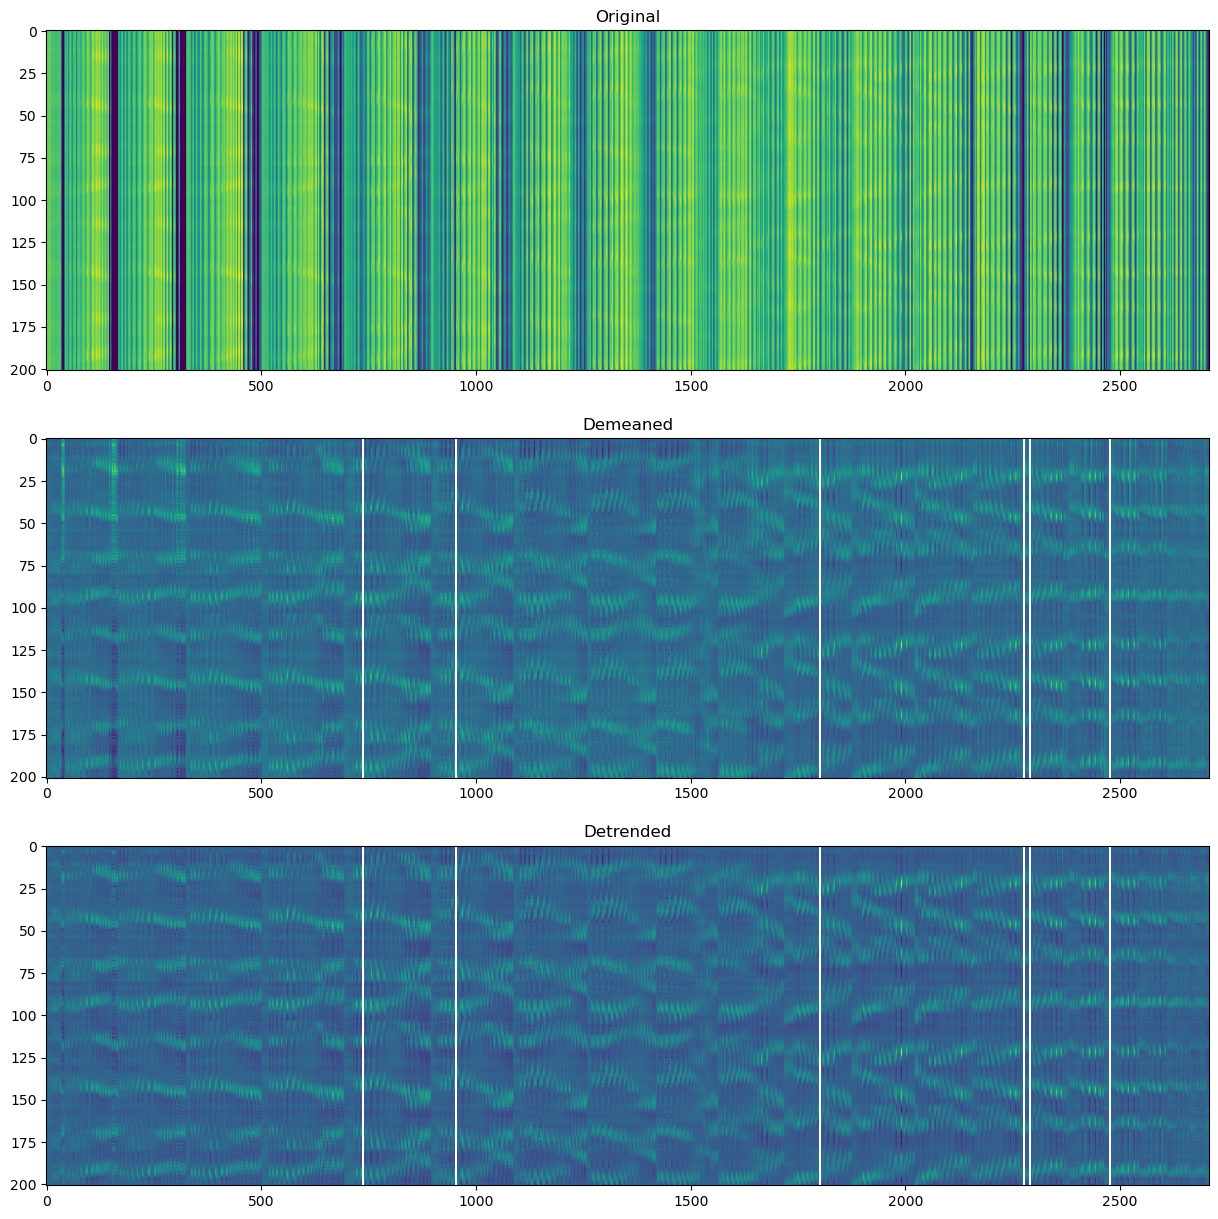

In [6]:
# vis_data = scan_data[visual_rois]
# vis_data = scan_data.flatten()[vis_idx]
vis_data = scan_data[vis_idx]
vis_data_demean = remove_trend(vis_data, method='demean')
vis_data_detrend = remove_trend(vis_data, method='all')

f, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].imshow(vis_data.T, cmap='viridis', aspect='auto', vmin=5000)
# ax[0].set_colorbar()
ax[0].set_title('Original')
ax[1].imshow(vis_data_demean.T, cmap='viridis', aspect='auto')
# ax[1].set_colorbar()
ax[1].set_title('Demeaned')
ax[2].imshow(vis_data_detrend.T, cmap='viridis', aspect='auto')
# ax[2].set_colorbar()
ax[2].set_title('Detrended')
plt.show()


# plt.figure(figsize=(15, 5))
# plt.imshow(vis_data[:, :].T, cmap='viridis', aspect='auto')
# plt.colorbar()
# plt.show()
# bsp.plot_hemispheres(lh_v1, rh_v1, embed_nb=True, color_bar=True, title='V1', zoom=1.5)

In [17]:
np.geomspace(-2*stimulus.deg_x0.max(), -stimulus.deg_x0.max(), Ns//2)

array([-24.25732554, -22.77595276, -21.38504607, -20.07908078,
       -18.8528696 , -17.70154202, -16.62052497, -15.60552465,
       -14.65250947, -13.75769406, -12.91752421, -12.12866277])

Number of grid points: 55296
Number of grid points after dropping: 27808


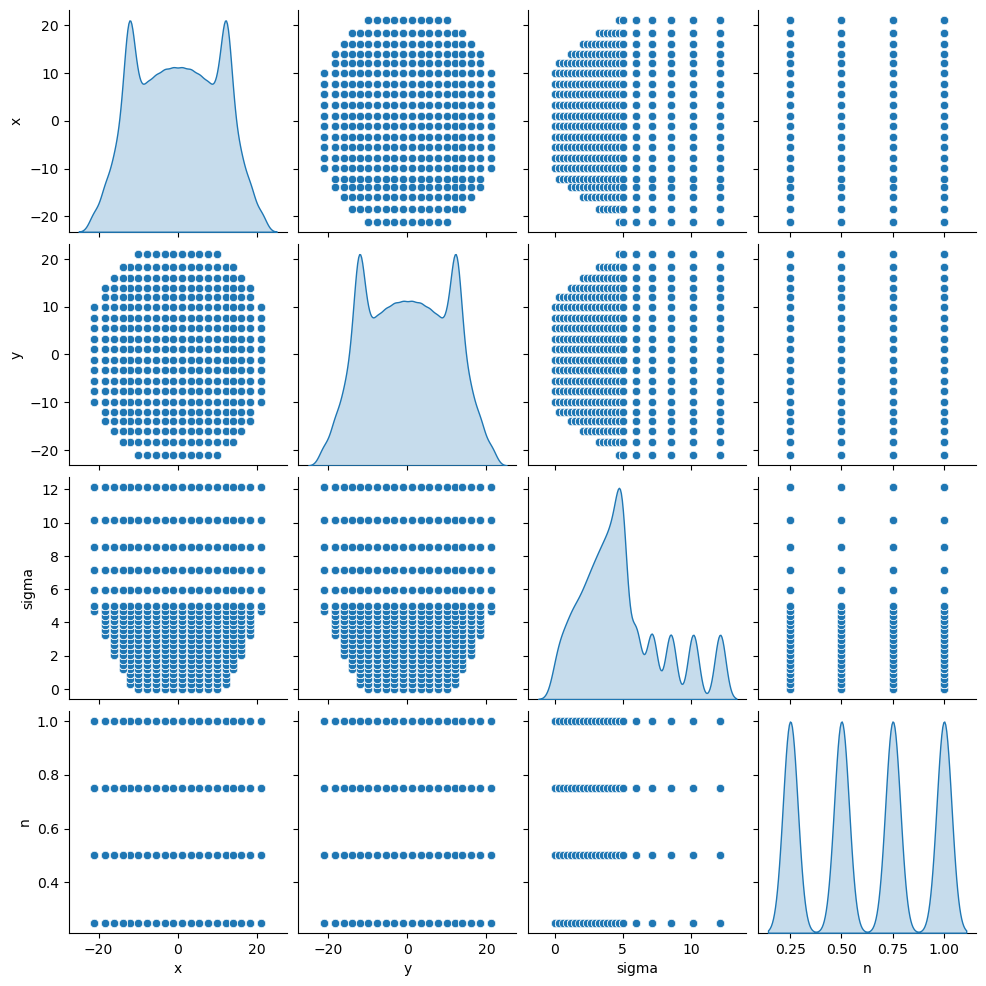

In [27]:
from itertools import product
import seaborn as sns
import pandas as pd
Ns = 25
x_grid = np.concatenate((np.linspace(-stimulus.deg_x0.max(), stimulus.deg_x0.max(), Ns//2),
                        np.geomspace(-stimulus.deg_x0.max(), -2*stimulus.deg_x0.max(), Ns//4),
                        np.geomspace(stimulus.deg_x0.max(), 2*stimulus.deg_x0.max(), Ns//4)))
y_grid = np.concatenate((np.linspace(-stimulus.deg_y0.max(), stimulus.deg_y0.max(), Ns//2),
                        np.geomspace(-stimulus.deg_y0.max(), -2*stimulus.deg_y0.max(), Ns//4),
                        np.geomspace(stimulus.deg_y0.max(), 2*stimulus.deg_y0.max(), Ns//4)))

# x_grid = np.linspace(-2*stimulus.deg_x0.max(), 2*stimulus.deg_x0.max(), Ns)#, dtype='float16')
# y_grid = np.linspace(-2*stimulus.deg_y0.max(), 2*stimulus.deg_y0.max(), Ns)#, dtype='float16')
s_grid = np.concatenate((np.linspace(0, 5, 3*Ns//4), np.geomspace(5, stimulus.deg_x0.max(), Ns//4)))
n_grid = np.asarray([0.25, 0.5, 0.75, 1])
grid_space = list(product(x_grid, y_grid, s_grid, n_grid))

grid_space = list(product(x_grid, y_grid, s_grid, n_grid))
print(f'Number of grid points: {len(grid_space)}')
idxs_to_drop = []
for i in range(len(grid_space)):
    if np.sqrt(grid_space[i][0]**2 + grid_space[i][1]**2) >= 2*stimulus.deg_x0.max():
        idxs_to_drop.append(i)
    if np.sqrt(grid_space[i][0]**2 + grid_space[i][1]**2) >= stimulus.deg_x0.max() + 2*grid_space[i][2]:
        idxs_to_drop.append(i)
grid_space = [grid_space[i] for i in range(len(grid_space)) if i not in idxs_to_drop]
print(f'Number of grid points after dropping: {len(grid_space)}')

df = pd.DataFrame(grid_space, columns=['x', 'y', 'sigma', 'n'])
sns.pairplot(df, diag_kind='kde', kind='scatter', markers='o')
plt.show()

In [40]:
x_grid = [-13.71066226, -12.91966252, -12.12866277, -11.33766302, -10.54666328]
y_grid = [-2.6846052,  -1.89360545, -1.10260571, -0.31160596,  0.47939379]
s_grid = [1.30642643, 1.5679191,  1.82941176, 2.09090443, 2.3523971 ]
n_grid = [0.25, 0.5, 0.75, 1]
gridspace_orig = list(product(x_grid, y_grid, s_grid, n_grid))

for ii in range(len(gridspace_orig)):
    if np.sqrt(gridspace_orig[ii][0]**2 + gridspace_orig[ii][1]**2) >= 2*stimulus.deg_x0.max():
        print(gridspace_orig[ii])
    if np.sqrt(gridspace_orig[ii][0]**2 + gridspace_orig[ii][1]**2) >= stimulus.deg_x0.max() + 2*gridspace_orig[ii][2]:
        print(gridspace_orig[ii])

# df = pd.DataFrame(gridspace_orig, columns=['x', 'y', 'sigma', 'n'])
# sns.pairplot(df, diag_kind='kde', kind='scatter', markers='o')
# plt.show()
# print(f'Number of grid points: {len(gridspace_orig)}')

# from fit_utils import *
grid_space = constraint_grids(gridspace_orig, stimulus)
# print(f'Number of grid points after constraint: {len(grid_space)}')



Number of grid points: 500
0 0
Number of grid points after dropping: 500


ValueError: BUG: filter coefficient a[0] == 0 not supported yet

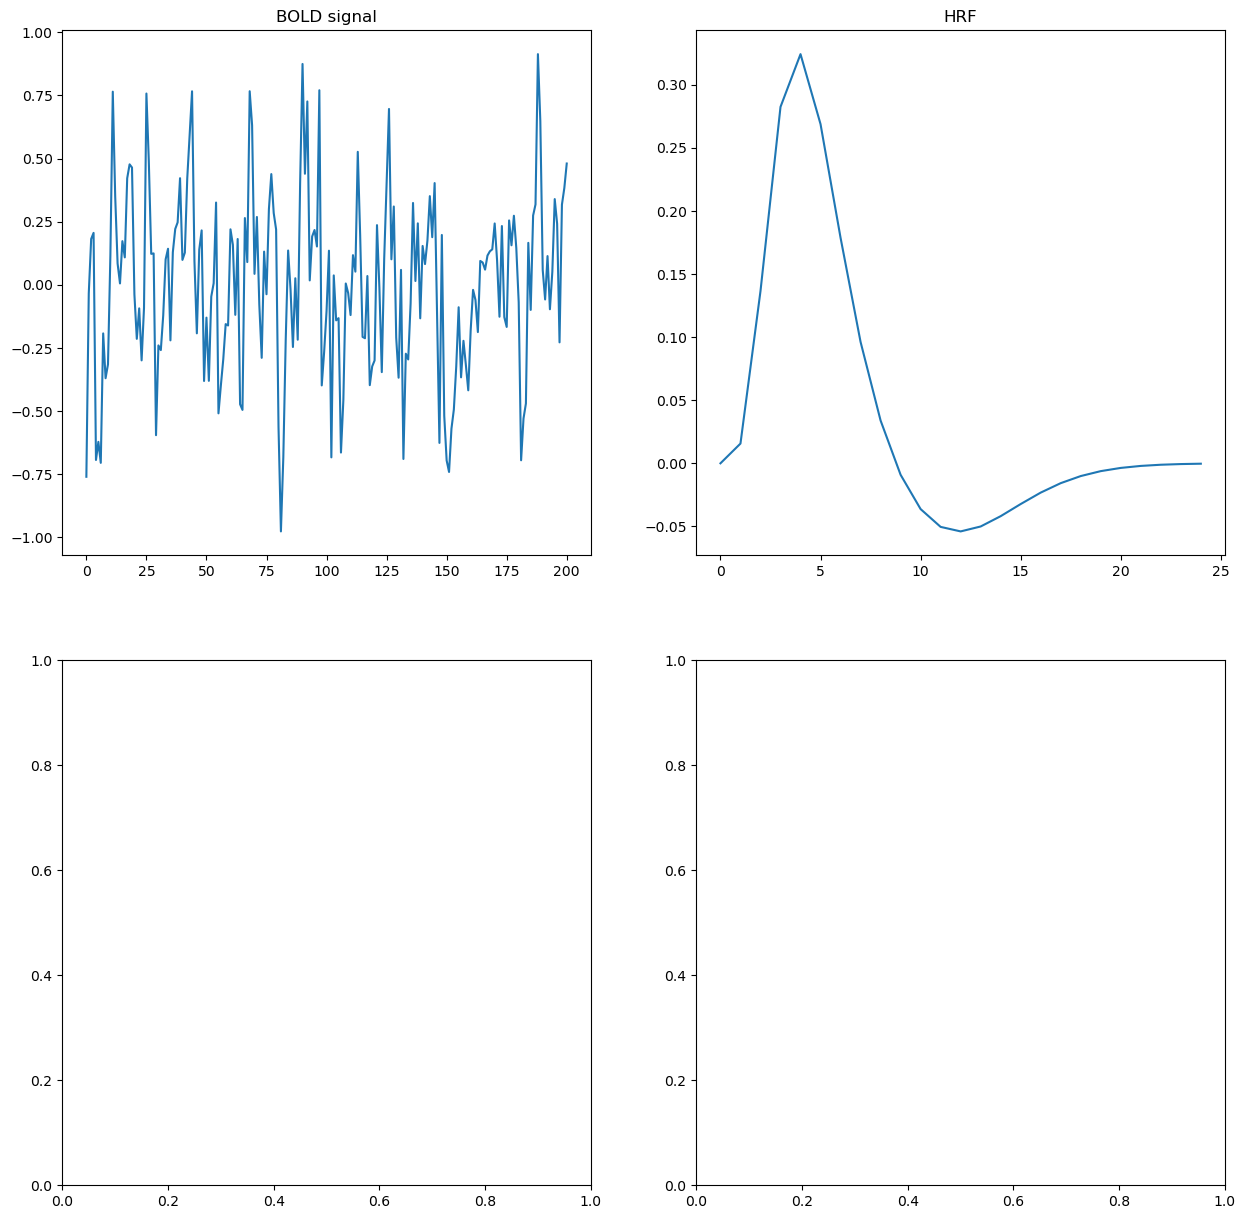

In [33]:
from scipy.signal import deconvolve
scan_vis = scan_data[visual_rois]
scan_vis = remove_trend(scan_vis, method='all')
hrf = utils.double_gamma_hrf(0, 1.3)
f, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0, 0].plot(scan_vis[100, :])
axs[0, 0].set_title('BOLD signal')
axs[0, 1].plot(hrf)
axs[0, 1].set_title('HRF')
response, remainder = deconvolve(scan_vis[0, :], hrf)
axs[1, 0].plot(response)
axs[1, 0].set_title('Response')
axs[1, 1].plot(remainder)
axs[1, 1].set_title('Remainder')
plt.show()
# scan_vis.shape

In [ ]:
# Find voxels that have nans in detrended
nan_voxels = np.isnan(vis_data_detrend).any(axis=1)
# Get indices of nan voxels
nan_voxels_idx = np.where(nan_voxels)[0]
# Plot the nan voxels
f, axs = plt.subplots(3, len(nan_voxels_idx), figsize=(15, 5))
for i in range(len(nan_voxels_idx)):
    axs[0,i].plot(vis_data[nan_voxels_idx[i], :])
    axs[1,i].plot(vis_data_demean[nan_voxels_idx[i], :])
    axs[2,i].plot(vis_data_detrend[nan_voxels_idx[i], :])
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(np.log(np.var(vis_data_detrend, axis=1)), bins=100)
plt.show()

In [ ]:
trueFit_data = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'mrVistaFit/RF_ss5-fFit.nii.gz')).get_fdata()
# Find ix, iy, iz for nan voxels
var_voxels_idx = np.where(np.var(vis_data_detrend, axis=1) < 0.03)[0]
print('Number of voxels with low variance: ', len(var_voxels_idx))
for i in range(len(var_voxels_idx)):
    ix, iy, iz = vis_idx[0][var_voxels_idx[i]], vis_idx[1][var_voxels_idx[i]], vis_idx[2][var_voxels_idx[i]]
    print('Voxel: ', var_voxels_idx[i])
    print(trueFit_data[ix, iy, iz, :])


In [ ]:
np.sum(visual_rois)

In [ ]:
tmp_data = trueFit_data.copy()
tmp_data[~visual_rois] = np.nan
r2_vals = tmp_data[:, :, :, 1].flatten()
pol_vals = tmp_data[:, :, :, 0].flatten()
rho_vals = tmp_data[:, :, :, 2].flatten()
sig_vals = tmp_data[:, :, :, 3].flatten()
n_vals = tmp_data[:, :, :, 4].flatten()
x_vals = tmp_data[:, :, :, 5].flatten()
y_vals = tmp_data[:, :, :, 6].flatten()
beta_vals = tmp_data[:, :, :, 7].flatten()
import pandas as pd
import seaborn as sns
# df = pd.DataFrame({'r2': r2_vals, 'pol': pol_vals, 'rho': rho_vals, 'sig': sig_vals, 'x': x_vals, 'y': y_vals})
df = pd.DataFrame({'r2': r2_vals, 'pol': pol_vals, 'rho': rho_vals, 'sig': sig_vals, 'n': n_vals, 'x': x_vals, 'y': y_vals, 'beta': beta_vals})
df = df.dropna()
# df 
plt.figure(figsize=(20, 20))
sns.pairplot(df, diag_kind='hist', plot_kws={'alpha': 0.5, 's': 3})
plt.show() 

In [ ]:
css_model = prfModels.CompressiveSpatialSummationModel(stimulus, utils.double_gamma_hrf, normalizer=utils.percent_change)
css_model.hrf_delay = 0
css_model.mask_size = 5 # standard deviations of the gaussian

[xi, yi, zi] = np.nonzero(visual_rois)
indices = [(xi[i], yi[i], zi[i]) for i in range(len(xi))]
num_voxels = len(indices)
# Create scan data just for visual ROIs
scan_data_visual = scan_data.copy()
scan_data_visual[~visual_rois] = 0
timeseries_data = scan_data_visual[xi, yi, zi, :]

# set search grids
Ns = 4
# x_grid = utils.grid_slice(-12.4, 12.4, 5)
# y_grid = utils.grid_slice(-12.4, 12.4, 5)
x_grid = utils.grid_slice(css_model.stimulus.deg_x0.min(), css_model.stimulus.deg_x0.max(), 5)
y_grid = utils.grid_slice(css_model.stimulus.deg_y0.min(), css_model.stimulus.deg_y0.max(), 5)
s_grid = utils.grid_slice(1/css_model.stimulus.ppd0, 7, Ns)
n_grid = utils.grid_slice(0.25, 1, Ns)
grids = (x_grid, y_grid, s_grid, n_grid,)

# Set search bounds
x_bounds = (-15.0, 15.0)
y_bounds = (-15.0, 15.0)
s_bounds = (1/css_model.stimulus.ppd0, 10)
n_bounds = (0.001, 1)
b_bounds = (1e-8, None)
m_bounds = (None, None)
bounds = (x_bounds, y_bounds, s_bounds, n_bounds, b_bounds, m_bounds)

verbose = 0
auto_fit = 1

In [ ]:
# Create a result holder
RF_ss5_gFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 9))
RF_ss5_fFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 9))
vx_indices = np.argwhere(visual_rois)

In [ ]:
def process_voxel(ii):

    if np.mod(ii, len(indices)//10) == 0:
        run_time = time.time() - start_time
        if run_time < 60:
            print(f"Completed: {round(ii/len(indices)*100, 2)}%, time: {round(run_time, 2)} s ")
        elif run_time < 3600:
            print(f"Completed: {round(ii/len(indices)*100, 2)}%, time: {int(np.floor(run_time/60))} min {round(run_time%60)} s")
        else:
            print(f"Completed: {round(ii/len(indices)*100, 2)}%, time: {int(np.floor(run_time/3600))} h {int(np.floor(run_time%3600/60))} min {round(run_time%60)} s")
    voxel_data = timeseries_data[ii, :]
    fit = prfModels.CompressiveSpatialSummationFit(
        css_model,
        voxel_data,
        grids,
        bounds,
        indices[ii],
        auto_fit=auto_fit,
        grid_only=False,
        verbose=verbose
    )
    return (indices[ii][0], indices[ii][1], indices[ii][2], fit.theta0, fit.rsquared0, fit.rho0, fit.s0, fit.n0, fit.x0, fit.y0, fit.beta0, fit.baseline0,
                        fit.theta, fit.rsquared, fit.rho, fit.sigma, fit.n, fit.x, fit.y, fit.beta, fit.baseline)


start_time = time.time()

futures = []
with ThreadPoolExecutor() as executor:
    for ii in range(len(indices)):
        futures.append(executor.submit(process_voxel, ii))

results = [f.result() for f in futures]

for result in results:
    if result is not None:
        ix, iy, iz, theta0, rsquared0, rho0, sigma0, n0, x0, y0, beta0, baseline0, theta, rsquared, rho, sigma, n, x, y, beta, baseline = result
        # Get the grid fit estimates
        RF_ss5_gFit[ix, iy, iz, 0] = theta0
        RF_ss5_gFit[ix, iy, iz, 1] = rsquared0
        RF_ss5_gFit[ix, iy, iz, 2] = rho0
        RF_ss5_gFit[ix, iy, iz, 3] = sigma0
        RF_ss5_gFit[ix, iy, iz, 4] = n0
        RF_ss5_gFit[ix, iy, iz, 5] = x0
        RF_ss5_gFit[ix, iy, iz, 6] = y0
        RF_ss5_gFit[ix, iy, iz, 7] = beta0
        RF_ss5_gFit[ix, iy, iz, 8] = baseline0

        # Get the full fit estimates
        RF_ss5_fFit[ix, iy, iz, 0] = theta
        RF_ss5_fFit[ix, iy, iz, 1] = rsquared
        RF_ss5_fFit[ix, iy, iz, 2] = rho
        RF_ss5_fFit[ix, iy, iz, 3] = sigma
        RF_ss5_fFit[ix, iy, iz, 4] = n
        RF_ss5_fFit[ix, iy, iz, 5] = x
        RF_ss5_fFit[ix, iy, iz, 6] = y
        RF_ss5_fFit[ix, iy, iz, 7] = beta
        RF_ss5_fFit[ix, iy, iz, 8] = baseline

end_time = time.time()
print()
print(f"Time taken for fitting: {end_time - start_time}")

In [ ]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax = axs.flatten()[i]
    ax.plot(trueFit_data[visual_rois, i].flatten(), RF_ss5_gFit[visual_rois, i].flatten(), 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Grid-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
plt.suptitle("Ballpark parameters")
plt.show()

In [ ]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax = axs.flatten()[i]
    # this_truth = trueFit_data[visual_rois, i]
    ax.plot(trueFit_data[visual_rois, i].flatten(), RF_ss5_fFit[visual_rois, i].flatten(), 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Final-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
plt.suptitle("Final parameters")
plt.show()

In [ ]:
RF_ss5_gFit[xi[vx], yi[vx], zi[vx], :]

In [ ]:
Ff

In [ ]:
vx = 0
Ff = trueFit_data[xi[vx], yi[vx], zi[vx], :]
rf = generate_og_receptive_field(Ff[5], Ff[6], Ff[3], stimulus.deg_x, stimulus.deg_y)
rf /=  ((2 * np.pi * Ff[3]**2) * 1/np.diff(stimulus.deg_x0[0,0:2])**2)

Ns = 4
# x_grid = utils.grid_slice(-12.4, 12.4, 10)
# y_grid = utils.grid_slice(-12.4, 12.4, 10)
# x_grid = utils.grid_slice(-29, 29, 20)
# y_grid = utils.grid_slice(-29, 29, 20)
# x_grid = utils.grid_slice(-11, 11, 10)
# y_grid = utils.grid_slice(-11, 11, 10)
x_grid = utils.grid_slice(css_model.stimulus.deg_x0.min(), css_model.stimulus.deg_x0.max(), 10)
y_grid = utils.grid_slice(css_model.stimulus.deg_y0.min(), css_model.stimulus.deg_y0.max(), 10)
s_grid = utils.grid_slice(1/css_model.stimulus.ppd0, 7, Ns)
n_grid = utils.grid_slice(0.25, 1, Ns)
grids = (x_grid, y_grid, s_grid, n_grid,)

output = brute(error_function_rss_me,
               args=(timeseries_data[vx, :], generate_ballpark_prediction_me, 0),
               ranges=grids,
               finish=None,
               full_output=True,
               disp=True,)
predicted_sig = generate_prediction_me(*np.append(output[0], (1,0)), unscaled=False)
# predicted_sig = generate_ballpark_prediction_me(*np.append(output[0], 0), timeseries_data[vx, :])
slope, intercept = linregress(predicted_sig, timeseries_data[vx, :])[:2]
grid_estim = np.append(output[0], (slope, intercept))
print("Grid-fit estimates: ", grid_estim)

x_bounds = (-29.0, 29.0)
y_bounds = (-29.0, 29.0)
s_bounds = (1/css_model.stimulus.ppd0, 10)
n_bounds = (1e-8, 1)
b_bounds = (1e-8, None)
m_bounds = (None, None)
bounds = (x_bounds, y_bounds, s_bounds, n_bounds, b_bounds, m_bounds)
# bounds = (x_bounds, y_bounds, s_bounds, n_bounds, b_bounds)


finout = minimize(utils.error_function_rss,
         grid_estim,
         bounds=bounds,
         method='L-BFGS-B',
        #  method = 'SLSQP',
         args=(timeseries_data[vx, :], generate_prediction_me, 0),
)
print("Final-fit estimates: ", finout.x)

rsq = 1 - finout.fun / np.sum((timeseries_data[vx, :] - np.mean(timeseries_data[vx, :]))**2)
print("R-squared: ", rsq)

f, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0,0].imshow(rf)
axs[0,0].set_title('Ground truth RF')

axs[0,1].plot(timeseries_data[vx, :], label='Data')
axs[0,1].plot(predicted_sig*slope + intercept, label='Grid-fit')
axs[0,1].plot(generate_prediction_me(*finout.x, unscaled=False), label='Final-fit')
axs[0,1].legend()
plt.show()

In [ ]:
def process_voxel_outside(ii):

    if np.mod(ii, len(indices)//10) == 0:
        run_time = time.time() - start_time
        if run_time < 60:
            print(f"Completed: {round(ii/len(indices)*100, 2)}%, time: {round(run_time, 2)} s ")
        elif run_time < 3600:
            print(f"Completed: {round(ii/len(indices)*100, 2)}%, time: {int(np.floor(run_time/60))} min {round(run_time%60)} s")
        else:
            print(f"Completed: {round(ii/len(indices)*100, 2)}%, time: {int(np.floor(run_time/3600))} h {int(np.floor(run_time%3600/60))} min {round(run_time%60)} s")
    voxel_data = timeseries_data[ii, :]
    output = brute(error_function_rss_me,
               args=(voxel_data, stimulus, generate_ballpark_prediction_me, 0),
               ranges=grids,
               finish=None,
               full_output=True,
               disp=False,)
    # predicted_sig = generate_prediction_me(*np.append(output[0], (1,0)), stimulus, unscaled=False)
    predicted_sig = generate_ballpark_prediction_me(*np.append(output[0], 0), stimulus, unscaled=True)
    slope, intercept = linregress(predicted_sig, voxel_data)[:2]
    grid_estim = np.append(output[0], (slope, intercept))
    finout = minimize(error_function_rss_blah,
         grid_estim,
         bounds=bounds,
        #  method='L-BFGS-B',
         method = 'SLSQP',
         args=(voxel_data, stimulus, generate_prediction_me, 0),
    )
    [x0, y0, sigma0, n0, beta0, baseline0] = grid_estim
    [x, y, sigma, n, beta, baseline] = finout.x
    theta0 = np.mod(np.arctan2(y0, x0), 2*np.pi)
    theta = np.mod(np.arctan2(y, x), 2*np.pi)
    rsquared0 = 1 - output[1] / np.sum((voxel_data - np.mean(voxel_data))**2)
    rsquared = 1 - finout.fun / np.sum((voxel_data - np.mean(voxel_data))**2)
    rho0 = np.sqrt(x0**2 + y0**2)
    rho = np.sqrt(x**2 + y**2)

    return(indices[ii][0], indices[ii][1], indices[ii][2], theta0, rsquared0, rho0, sigma0, n0, x0, y0, beta0, baseline0,
           theta, rsquared, rho, sigma, n, x, y, beta, baseline)


start_time = time.time()

futures = []
# with ThreadPoolExecutor() as executor:
with ThreadPoolExecutor() as executor:
    for ii in range(len(indices)):
        futures.append(executor.submit(process_voxel_outside, ii))

results = [f.result() for f in futures]

for result in results:
    if result is not None:
        ix, iy, iz, theta0, rsquared0, rho0, sigma0, n0, x0, y0, beta0, baseline0, theta, rsquared, rho, sigma, n, x, y, beta, baseline = result
        # Get the grid fit estimates
        RF_ss5_gFit[ix, iy, iz, 0] = theta0
        RF_ss5_gFit[ix, iy, iz, 1] = rsquared0
        RF_ss5_gFit[ix, iy, iz, 2] = rho0
        RF_ss5_gFit[ix, iy, iz, 3] = sigma0
        RF_ss5_gFit[ix, iy, iz, 4] = n0
        RF_ss5_gFit[ix, iy, iz, 5] = x0
        RF_ss5_gFit[ix, iy, iz, 6] = y0
        RF_ss5_gFit[ix, iy, iz, 7] = beta0
        RF_ss5_gFit[ix, iy, iz, 8] = baseline0

        # Get the full fit estimates
        RF_ss5_fFit[ix, iy, iz, 0] = theta
        RF_ss5_fFit[ix, iy, iz, 1] = rsquared
        RF_ss5_fFit[ix, iy, iz, 2] = rho
        RF_ss5_fFit[ix, iy, iz, 3] = sigma
        RF_ss5_fFit[ix, iy, iz, 4] = n
        RF_ss5_fFit[ix, iy, iz, 5] = x
        RF_ss5_fFit[ix, iy, iz, 6] = y
        RF_ss5_fFit[ix, iy, iz, 7] = beta
        RF_ss5_fFit[ix, iy, iz, 8] = baseline

end_time = time.time()
print()
print(f"Time taken for fitting: {end_time - start_time}")

In [ ]:
# Plot histograms for each parameter in RF_sst_fFit
f, axs = plt.subplots(3, 3, figsize=(20, 10))
for i in range(9):
    ax = axs.flatten()[i]
    ax.hist(RF_ss5_fFit[visual_rois, i].flatten(), bins=50)
    ax.set_title(f"Final-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta', 'baseline'][i]}")
plt.suptitle("Final parameters")
plt.show()

In [ ]:
# Save the results
anat_data = nib.load(p['pRF_anat']) #.get_fdata()
# popeye_fFit = nib.Nifti1Image(RF_ss5_fFit, affine=anat_data.affine, header=anat_data.header)
popeye_fFit = nib.nifti1.Nifti1Image(RF_ss5_fFit, affine=func_data.affine, header=func_data.header)
# popeye_gFit = nib.Nifti1Image(RF_ss5_gFit, affine=anat_data.affine, header=anat_data.header)
popeye_gFit = nib.nifti1.Nifti1Image(RF_ss5_gFit, affine=func_data.affine, header=func_data.header)
if not os.path.exists(os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit')):
    os.makedirs(os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit'))
nib.save(popeye_fFit, os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit', 'RF_ss5_fFit_popeye.nii.gz'))
nib.save(popeye_gFit, os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit', 'RF_ss5_gFit_popeye.nii.gz'))